In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import (
    classification_report, confusion_matrix, 
    roc_auc_score, roc_curve, precision_recall_curve,
    f1_score, precision_score, recall_score, accuracy_score
)
import json
import joblib
from datetime import datetime
import warnings

warnings.filterwarnings('ignore')

# Set visualization style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

print("✓ All libraries imported successfully")

✓ All libraries imported successfully


In [2]:
# Load the preprocessed data
print("="*50)
print("LOADING DATA")
print("="*50)

train_df = pd.read_csv('../data/processed/train.csv')
val_df = pd.read_csv('../data/processed/validation.csv')
test_df = pd.read_csv('../data/processed/test.csv')

# Load feature info
with open('../data/processed/feature_info.json', 'r') as f:
    feature_info = json.load(f)

feature_columns = feature_info['feature_columns']

print(f"✓ Training set:   {len(train_df):,} samples")
print(f"✓ Validation set: {len(val_df):,} samples")
print(f"✓ Test set:       {len(test_df):,} samples")
print(f"✓ Features:       {len(feature_columns)}")

LOADING DATA
✓ Training set:   27,478 samples
✓ Validation set: 5,870 samples
✓ Test set:       5,886 samples
✓ Features:       21


In [3]:
# Prepare data splits
X_train = train_df[feature_columns]
y_train = train_df['isMalicious']
text_train = train_df['prompt_cleaned']

X_val = val_df[feature_columns]
y_val = val_df['isMalicious']
text_val = val_df['prompt_cleaned']

X_test = test_df[feature_columns]
y_test = test_df['isMalicious']
text_test = test_df['prompt_cleaned']

print(f"\n✓ Data prepared for modeling")


✓ Data prepared for modeling


In [4]:
def evaluate_model(y_true, y_pred, y_pred_proba, model_name, dataset_name="Validation"):
    """
    Comprehensive model evaluation with security-focused metrics
    
    Args:
        y_true: True labels
        y_pred: Predicted labels (binary)
        y_pred_proba: Predicted probabilities
        model_name: Name of the model
        dataset_name: Name of dataset (for display)
    
    Returns:
        Dictionary of metrics
    """
    print(f"\n{'='*60}")
    print(f"{model_name} - {dataset_name} Set Performance")
    print(f"{'='*60}")
    
    # Calculate metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    roc_auc = roc_auc_score(y_true, y_pred_proba)
    
    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    
    # Additional metrics
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    fpr = fp / (fp + tn) if (fp + tn) > 0 else 0  # False Positive Rate
    fnr = fn / (fn + tp) if (fn + tp) > 0 else 0  # False Negative Rate
    
    print(f"\n📊 CLASSIFICATION METRICS:")
    print(f"   Accuracy:   {accuracy:.4f} ({accuracy*100:.2f}%)")
    print(f"   Precision:  {precision:.4f} ({precision*100:.2f}%)")
    print(f"   Recall:     {recall:.4f} ({recall*100:.2f}%)")
    print(f"   F1-Score:   {f1:.4f}")
    print(f"   ROC-AUC:    {roc_auc:.4f}")
    print(f"   Specificity: {specificity:.4f}")
    
    print(f"\n🎯 CONFUSION MATRIX BREAKDOWN:")
    print(f"   True Negatives (TN):  {tn:,} ✓ Correctly identified benign")
    print(f"   False Positives (FP): {fp:,} ✗ Benign flagged as malicious")
    print(f"   False Negatives (FN): {fn:,} ⚠️  DANGEROUS - Malicious missed")
    print(f"   True Positives (TP):  {tp:,} ✓ Correctly caught malicious")
    
    print(f"\n⚠️  ERROR RATES:")
    print(f"   False Positive Rate: {fpr:.4f} ({fpr*100:.2f}%)")
    print(f"   False Negative Rate: {fnr:.4f} ({fnr*100:.2f}%) {'⚠️ HIGH RISK' if fnr > 0.05 else '✓ Acceptable'}")
    
    print(f"\n📈 CLASSIFICATION REPORT:")
    print(classification_report(y_true, y_pred, target_names=['Benign', 'Malicious']))
    
    # Return metrics dict
    return {
        'model_name': model_name,
        'dataset': dataset_name,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'roc_auc': roc_auc,
        'specificity': specificity,
        'true_negatives': int(tn),
        'false_positives': int(fp),
        'false_negatives': int(fn),
        'true_positives': int(tp),
        'fpr': fpr,
        'fnr': fnr
    }

In [5]:
def plot_confusion_matrix(y_true, y_pred, model_name, dataset_name="Validation"):
    """Plot confusion matrix heatmap"""
    cm = confusion_matrix(y_true, y_pred)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Benign', 'Malicious'],
                yticklabels=['Benign', 'Malicious'],
                cbar_kws={'label': 'Count'})
    plt.title(f'{model_name} - Confusion Matrix ({dataset_name})', 
              fontsize=14, fontweight='bold', pad=20)
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    
    # Add percentage annotations
    total = cm.sum()
    for i in range(2):
        for j in range(2):
            pct = cm[i, j] / total * 100
            plt.text(j+0.5, i+0.7, f'({pct:.1f}%)', 
                    ha='center', va='center', fontsize=10, color='gray')
    
    plt.tight_layout()
    return plt.gcf()

In [6]:
def plot_roc_curve(y_true, y_pred_proba, model_name, ax=None):
    """Plot ROC curve"""
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)
    roc_auc = roc_auc_score(y_true, y_pred_proba)
    
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 6))
    
    ax.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.3f})', linewidth=2)
    ax.plot([0, 1], [0, 1], 'k--', label='Random Classifier', linewidth=1)
    ax.set_xlabel('False Positive Rate', fontsize=12)
    ax.set_ylabel('True Positive Rate (Recall)', fontsize=12)
    ax.set_title('ROC Curve', fontsize=14, fontweight='bold')
    ax.legend(loc='lower right')
    ax.grid(True, alpha=0.3)
    
    return ax

In [7]:
def plot_precision_recall_curve(y_true, y_pred_proba, model_name, ax=None):
    """Plot Precision-Recall curve"""
    precision, recall, thresholds = precision_recall_curve(y_true, y_pred_proba)
    
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 6))
    
    ax.plot(recall, precision, label=model_name, linewidth=2)
    ax.set_xlabel('Recall', fontsize=12)
    ax.set_ylabel('Precision', fontsize=12)
    ax.set_title('Precision-Recall Curve', fontsize=14, fontweight='bold')
    ax.legend(loc='best')
    ax.grid(True, alpha=0.3)
    
    # Add F1 contours
    f_scores = np.linspace(0.2, 0.8, num=4)
    for f_score in f_scores:
        x = np.linspace(0.01, 1)
        y = f_score * x / (2 * x - f_score)
        ax.plot(x[y >= 0], y[y >= 0], color='gray', alpha=0.3, linestyle='--', linewidth=1)
        ax.annotate(f'F1={f_score:.1f}', xy=(0.9, y[45] + 0.02), fontsize=9, color='gray')
    
    return ax

In [ ]:
print("\n" + "="*60)
print("BASELINE MODEL 1: TF-IDF + LOGISTIC REGRESSION")
print("="*60)

# TF-IDF (Term Frequency-Inverse Document Frequency): Converts text to numerical vectors, giving higher weight to words that are distinctive rather than common.
# Configure TF-IDF
print("\n1. Creating TF-IDF vectorizer...")
tfidf = TfidfVectorizer(
    max_features=5000,      # Keep top 5000 most important words
    ngram_range=(1, 3),     # Use 1-grams, 2-grams, and 3-grams
    min_df=2,               # Word must appear in at least 2 documents
    max_df=0.95,            # Ignore words that appear in >95% of documents
    strip_accents='unicode',
    lowercase=True,
    token_pattern=r'\b\w+\b'
)

# Fit on training data and transform all sets
print("2. Fitting TF-IDF on training data...")
X_train_tfidf = tfidf.fit_transform(text_train)
X_val_tfidf = tfidf.transform(text_val)
X_test_tfidf = tfidf.transform(text_val)  # We'll use test in Session 6

print(f"✓ TF-IDF vocabulary size: {len(tfidf.vocabulary_):,} terms")
print(f"✓ Training matrix shape: {X_train_tfidf.shape}")
print(f"✓ Validation matrix shape: {X_val_tfidf.shape}")

# Train Logistic Regression
print("\n3. Training Logistic Regression...")
lr_model = LogisticRegression(
    max_iter=1000,
    C=1.0,                  # Regularization strength (will tune later)
    class_weight='balanced', # Handle any residual imbalance
    random_state=42,
    solver='liblinear'
)

lr_model.fit(X_train_tfidf, y_train)
print("✓ Model trained successfully")

# Make predictions
print("\n4. Making predictions...")
y_train_pred_lr = lr_model.predict(X_train_tfidf)
y_train_proba_lr = lr_model.predict_proba(X_train_tfidf)[:, 1]

y_val_pred_lr = lr_model.predict(X_val_tfidf)
y_val_proba_lr = lr_model.predict_proba(X_val_tfidf)[:, 1]

print("✓ Predictions complete")


BASELINE MODEL 1: TF-IDF + LOGISTIC REGRESSION

1. Creating TF-IDF vectorizer...
2. Fitting TF-IDF on training data...
✓ TF-IDF vocabulary size: 5,000 terms
✓ Training matrix shape: (27478, 5000)
✓ Validation matrix shape: (5870, 5000)

3. Training Logistic Regression...
✓ Model trained successfully

4. Making predictions...
✓ Predictions complete


In [9]:
# Evaluate on training set (check for overfitting)
train_metrics_lr = evaluate_model(
    y_train, y_train_pred_lr, y_train_proba_lr,
    "Logistic Regression + TF-IDF",
    "Training"
)

# Evaluate on validation set (actual performance)
val_metrics_lr = evaluate_model(
    y_val, y_val_pred_lr, y_val_proba_lr,
    "Logistic Regression + TF-IDF",
    "Validation"
)


Logistic Regression + TF-IDF - Training Set Performance

📊 CLASSIFICATION METRICS:
   Accuracy:   0.9625 (96.25%)
   Precision:  0.9879 (98.79%)
   Recall:     0.9365 (93.65%)
   F1-Score:   0.9615
   ROC-AUC:    0.9894
   Specificity: 0.9886

🎯 CONFUSION MATRIX BREAKDOWN:
   True Negatives (TN):  13,582 ✓ Correctly identified benign
   False Positives (FP): 157 ✗ Benign flagged as malicious
   False Negatives (FN): 873 ⚠️  DANGEROUS - Malicious missed
   True Positives (TP):  12,866 ✓ Correctly caught malicious

⚠️  ERROR RATES:
   False Positive Rate: 0.0114 (1.14%)
   False Negative Rate: 0.0635 (6.35%) ⚠️ HIGH RISK

📈 CLASSIFICATION REPORT:
              precision    recall  f1-score   support

      Benign       0.94      0.99      0.96     13739
   Malicious       0.99      0.94      0.96     13739

    accuracy                           0.96     27478
   macro avg       0.96      0.96      0.96     27478
weighted avg       0.96      0.96      0.96     27478


Logistic Regressio

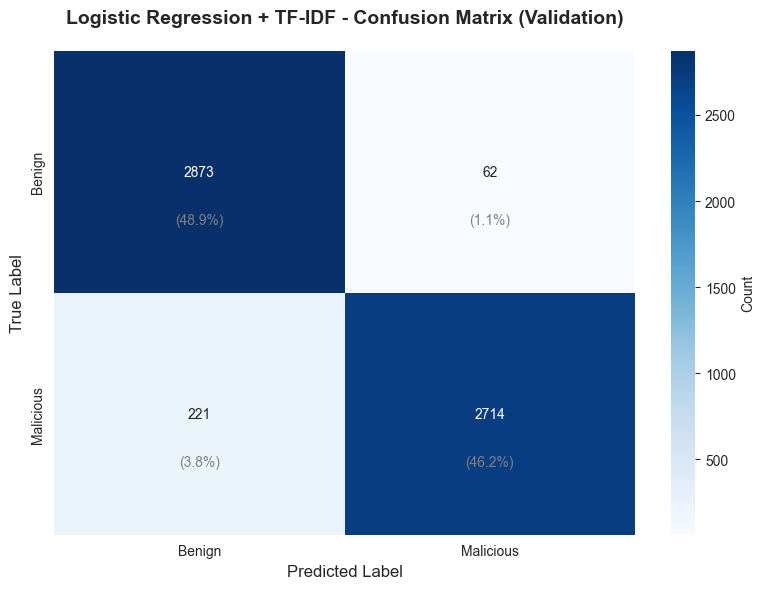

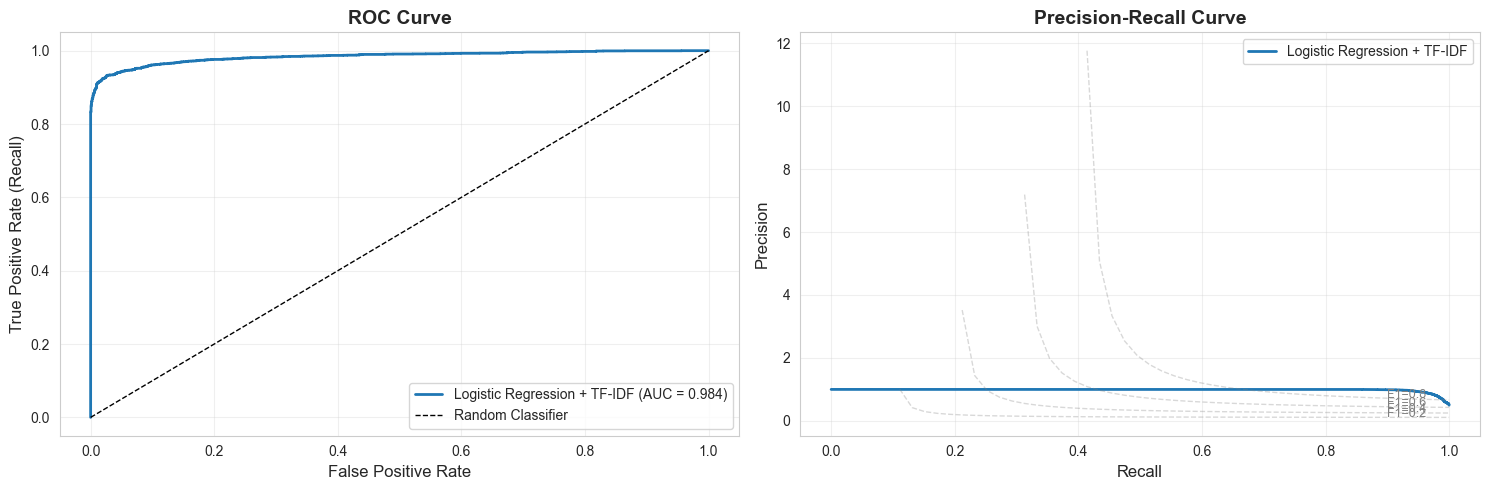

In [10]:
# Visualize results
fig = plot_confusion_matrix(y_val, y_val_pred_lr, "Logistic Regression + TF-IDF", "Validation")
plt.savefig('../notebooks/lr_confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

# ROC and PR curves
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
plot_roc_curve(y_val, y_val_proba_lr, "Logistic Regression + TF-IDF", ax=axes[0])
plot_precision_recall_curve(y_val, y_val_proba_lr, "Logistic Regression + TF-IDF", ax=axes[1])
plt.tight_layout()
plt.savefig('../notebooks/lr_curves.png', dpi=300, bbox_inches='tight')
plt.show()


MOST PREDICTIVE FEATURES (Words)

Top 20 most predictive features:
Feature                        Coefficient  Effect
------------------------------------------------------------
why                                -5.3064  → BENIGN
what                               -5.2992  → BENIGN
the                                 4.6908  → MALICIOUS
this                                4.5935  → MALICIOUS
how                                -4.3511  → BENIGN
forget                              4.2155  → MALICIOUS
and start                           4.1320  → MALICIOUS
ignore                              4.1141  → MALICIOUS
does                               -3.9027  → BENIGN
disregard                           3.8640  → MALICIOUS
overlook                            3.8374  → MALICIOUS
bypass                              3.7969  → MALICIOUS
omit                                3.7833  → MALICIOUS
neglect                             3.7821  → MALICIOUS
prior                               3.7700  → MA

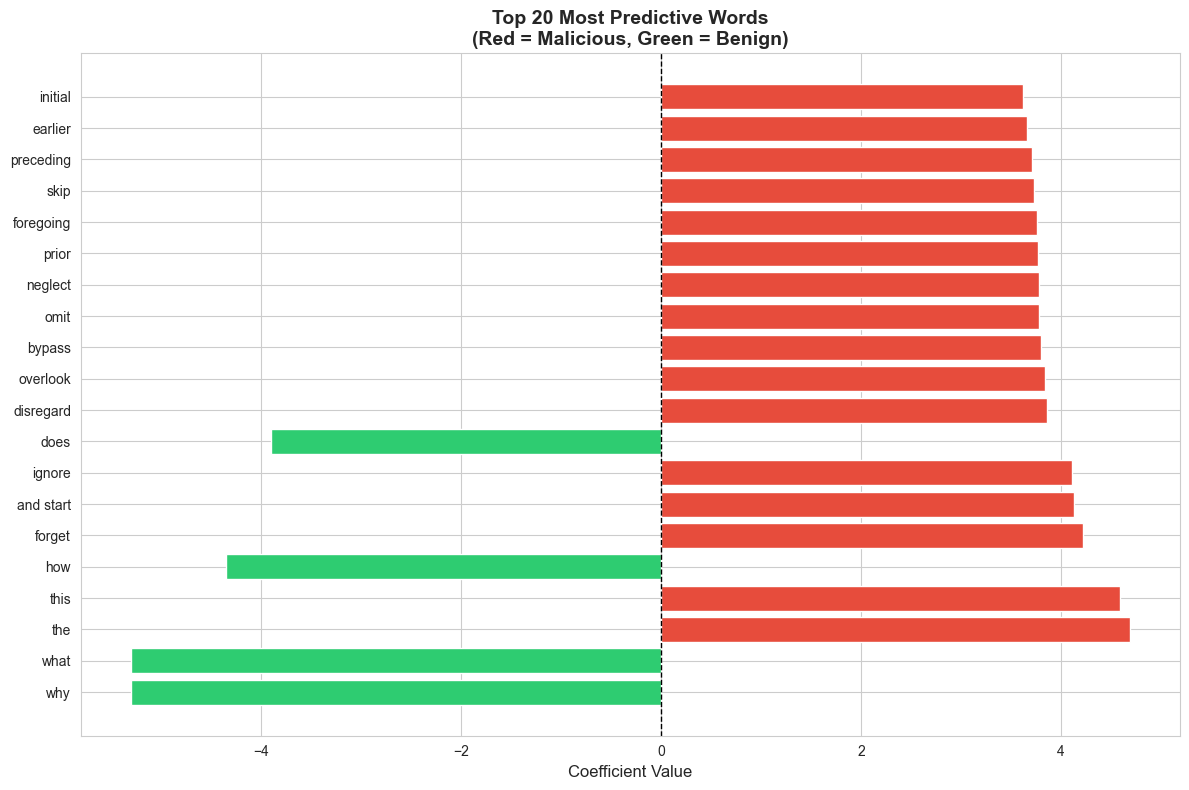

In [11]:
# Feature importance - most predictive words
print("\n" + "="*60)
print("MOST PREDICTIVE FEATURES (Words)")
print("="*60)

# Get feature names and coefficients
feature_names = np.array(tfidf.get_feature_names_out())
coefficients = lr_model.coef_[0]

# Sort by absolute coefficient value
top_indices = np.argsort(np.abs(coefficients))[-20:][::-1]

print("\nTop 20 most predictive features:")
print(f"{'Feature':<30} {'Coefficient':<12} {'Effect'}")
print("-" * 60)

for idx in top_indices:
    coef = coefficients[idx]
    effect = "→ MALICIOUS" if coef > 0 else "→ BENIGN"
    print(f"{feature_names[idx]:<30} {coef:>11.4f}  {effect}")

# Visualize
top_features_df = pd.DataFrame({
    'feature': feature_names[top_indices],
    'coefficient': coefficients[top_indices]
})

plt.figure(figsize=(12, 8))
colors = ['#e74c3c' if x > 0 else '#2ecc71' for x in top_features_df['coefficient']]
plt.barh(range(len(top_features_df)), top_features_df['coefficient'], color=colors)
plt.yticks(range(len(top_features_df)), top_features_df['feature'])
plt.xlabel('Coefficient Value', fontsize=12)
plt.title('Top 20 Most Predictive Words\n(Red = Malicious, Green = Benign)', 
          fontsize=14, fontweight='bold')
plt.axvline(x=0, color='black', linestyle='--', linewidth=1)
plt.tight_layout()
plt.savefig('../notebooks/lr_feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

In [12]:
print("\n" + "="*60)
print("BASELINE MODEL 2: RANDOM FOREST + ENGINEERED FEATURES")
print("="*60)

# We'll use the engineered features from Session 2
print(f"\nUsing {len(feature_columns)} engineered features")

# Train Random Forest
print("\n1. Training Random Forest...")
rf_model = RandomForestClassifier(
    n_estimators=100,       # Number of trees (will tune later)
    max_depth=20,           # Maximum tree depth
    min_samples_split=10,   # Minimum samples to split a node
    min_samples_leaf=4,     # Minimum samples in leaf node
    class_weight='balanced',
    random_state=42,
    n_jobs=-1,              # Use all CPU cores
    verbose=1
)

rf_model.fit(X_train, y_train)
print("✓ Model trained successfully")

# Make predictions
print("\n2. Making predictions...")
y_train_pred_rf = rf_model.predict(X_train)
y_train_proba_rf = rf_model.predict_proba(X_train)[:, 1]

y_val_pred_rf = rf_model.predict(X_val)
y_val_proba_rf = rf_model.predict_proba(X_val)[:, 1]

print("✓ Predictions complete")


BASELINE MODEL 2: RANDOM FOREST + ENGINEERED FEATURES

Using 21 engineered features

1. Training Random Forest...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.2s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s


✓ Model trained successfully

2. Making predictions...


[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.


✓ Predictions complete


[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.0s finished


In [13]:
# Evaluate
train_metrics_rf = evaluate_model(
    y_train, y_train_pred_rf, y_train_proba_rf,
    "Random Forest + Features",
    "Training"
)

val_metrics_rf = evaluate_model(
    y_val, y_val_pred_rf, y_val_proba_rf,
    "Random Forest + Features",
    "Validation"
)


Random Forest + Features - Training Set Performance

📊 CLASSIFICATION METRICS:
   Accuracy:   0.9454 (94.54%)
   Precision:  0.9924 (99.24%)
   Recall:     0.8976 (89.76%)
   F1-Score:   0.9426
   ROC-AUC:    0.9901
   Specificity: 0.9932

🎯 CONFUSION MATRIX BREAKDOWN:
   True Negatives (TN):  13,645 ✓ Correctly identified benign
   False Positives (FP): 94 ✗ Benign flagged as malicious
   False Negatives (FN): 1,407 ⚠️  DANGEROUS - Malicious missed
   True Positives (TP):  12,332 ✓ Correctly caught malicious

⚠️  ERROR RATES:
   False Positive Rate: 0.0068 (0.68%)
   False Negative Rate: 0.1024 (10.24%) ⚠️ HIGH RISK

📈 CLASSIFICATION REPORT:
              precision    recall  f1-score   support

      Benign       0.91      0.99      0.95     13739
   Malicious       0.99      0.90      0.94     13739

    accuracy                           0.95     27478
   macro avg       0.95      0.95      0.95     27478
weighted avg       0.95      0.95      0.95     27478


Random Forest + Feat

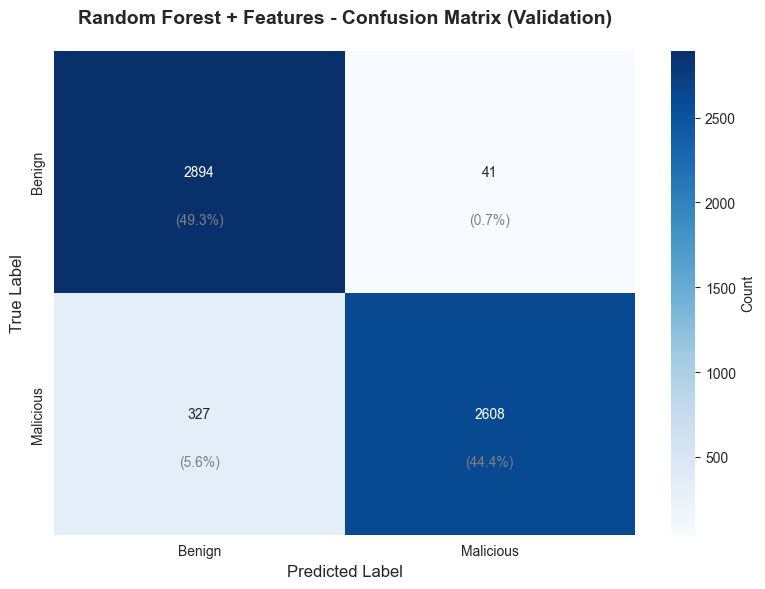

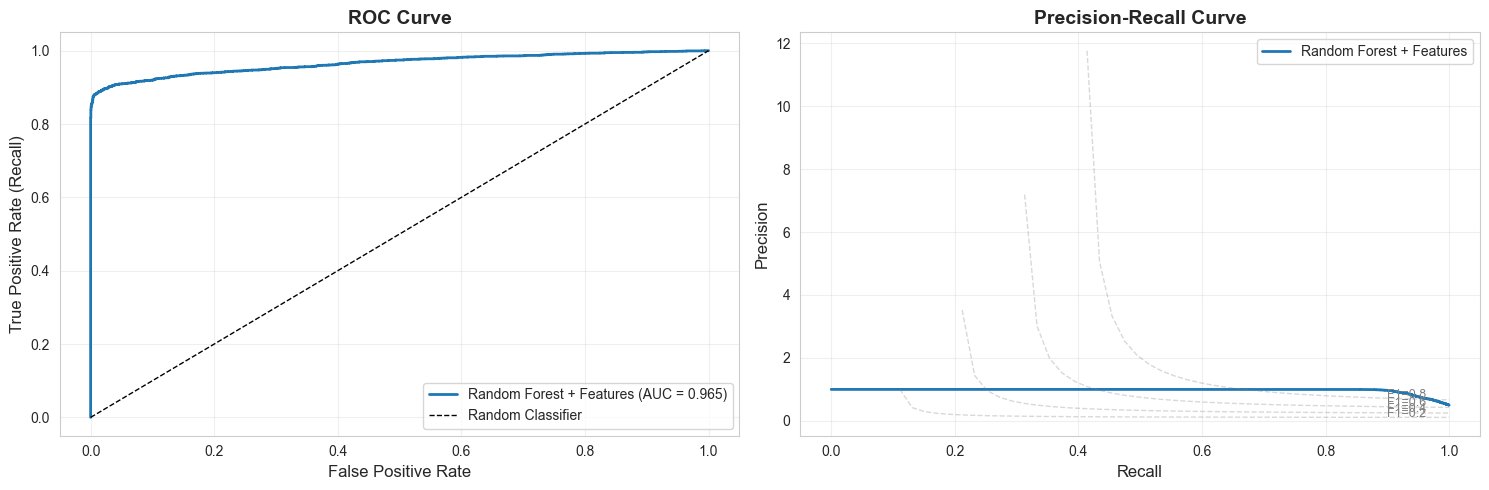

In [14]:
# Visualize results
fig = plot_confusion_matrix(y_val, y_val_pred_rf, "Random Forest + Features", "Validation")
plt.savefig('../notebooks/rf_confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

# ROC and PR curves
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
plot_roc_curve(y_val, y_val_proba_rf, "Random Forest + Features", ax=axes[0])
plot_precision_recall_curve(y_val, y_val_proba_rf, "Random Forest + Features", ax=axes[1])
plt.tight_layout()
plt.savefig('../notebooks/rf_curves.png', dpi=300, bbox_inches='tight')
plt.show()


FEATURE IMPORTANCE (Random Forest)

Top 15 most important features:
                  feature  importance
           sentence_count    0.295056
            prompt_length    0.159720
               word_count    0.115185
 total_injection_keywords    0.104266
          uppercase_count    0.091107
             char_entropy    0.049449
        lexical_diversity    0.037522
    context_keyword_count    0.033932
          avg_word_length    0.032946
          uppercase_ratio    0.030553
instruction_keyword_count    0.025504
       special_char_count    0.009861
              digit_count    0.006515
       special_char_ratio    0.004570
              digit_ratio    0.002699


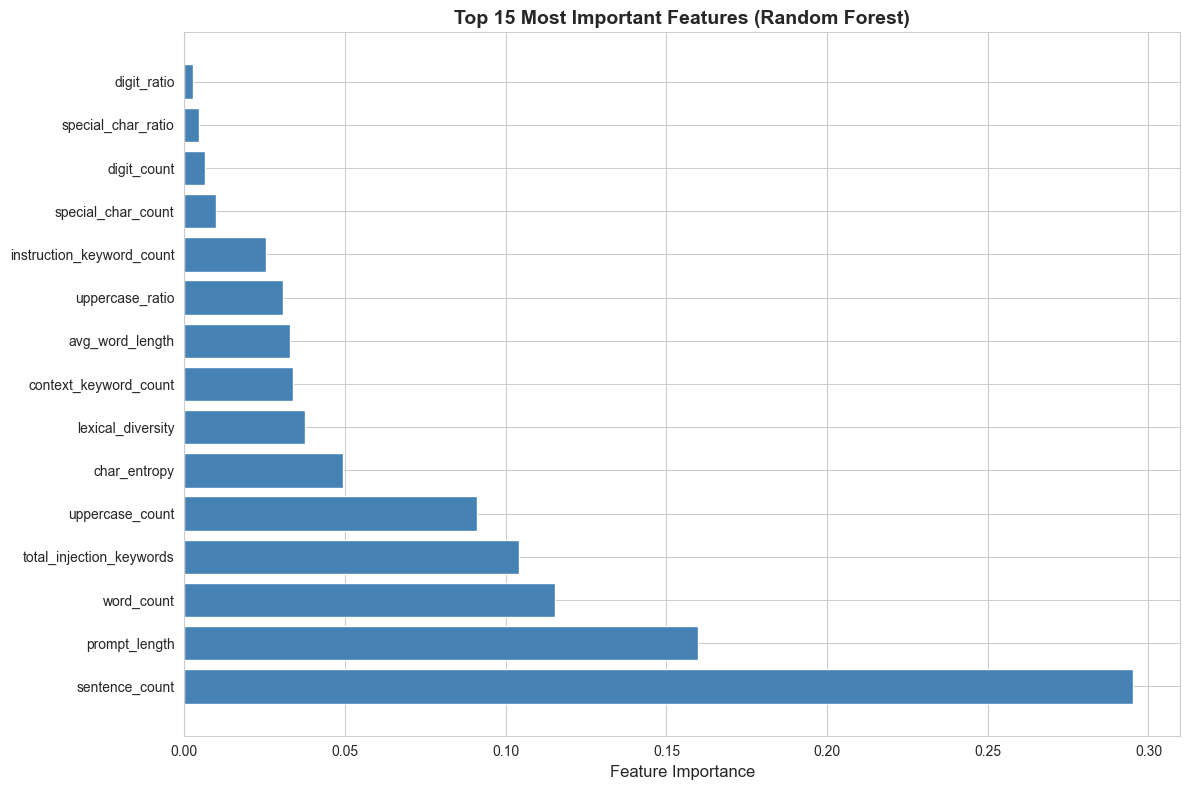

In [15]:
# Feature importance
print("\n" + "="*60)
print("FEATURE IMPORTANCE (Random Forest)")
print("="*60)

feature_importance = pd.DataFrame({
    'feature': feature_columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 15 most important features:")
print(feature_importance.head(15).to_string(index=False))

# Visualize
plt.figure(figsize=(12, 8))
top_15 = feature_importance.head(15)
plt.barh(range(len(top_15)), top_15['importance'], color='steelblue')
plt.yticks(range(len(top_15)), top_15['feature'])
plt.xlabel('Feature Importance', fontsize=12)
plt.title('Top 15 Most Important Features (Random Forest)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('../notebooks/rf_feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()


MODEL COMPARISON

Validation Set Performance:
                  model_name  accuracy  precision   recall       f1  roc_auc      fnr
Logistic Regression + TF-IDF  0.951789   0.977666 0.924702 0.950447 0.983949 0.075298
    Random Forest + Features  0.937308   0.984522 0.888586 0.934097 0.965365 0.111414


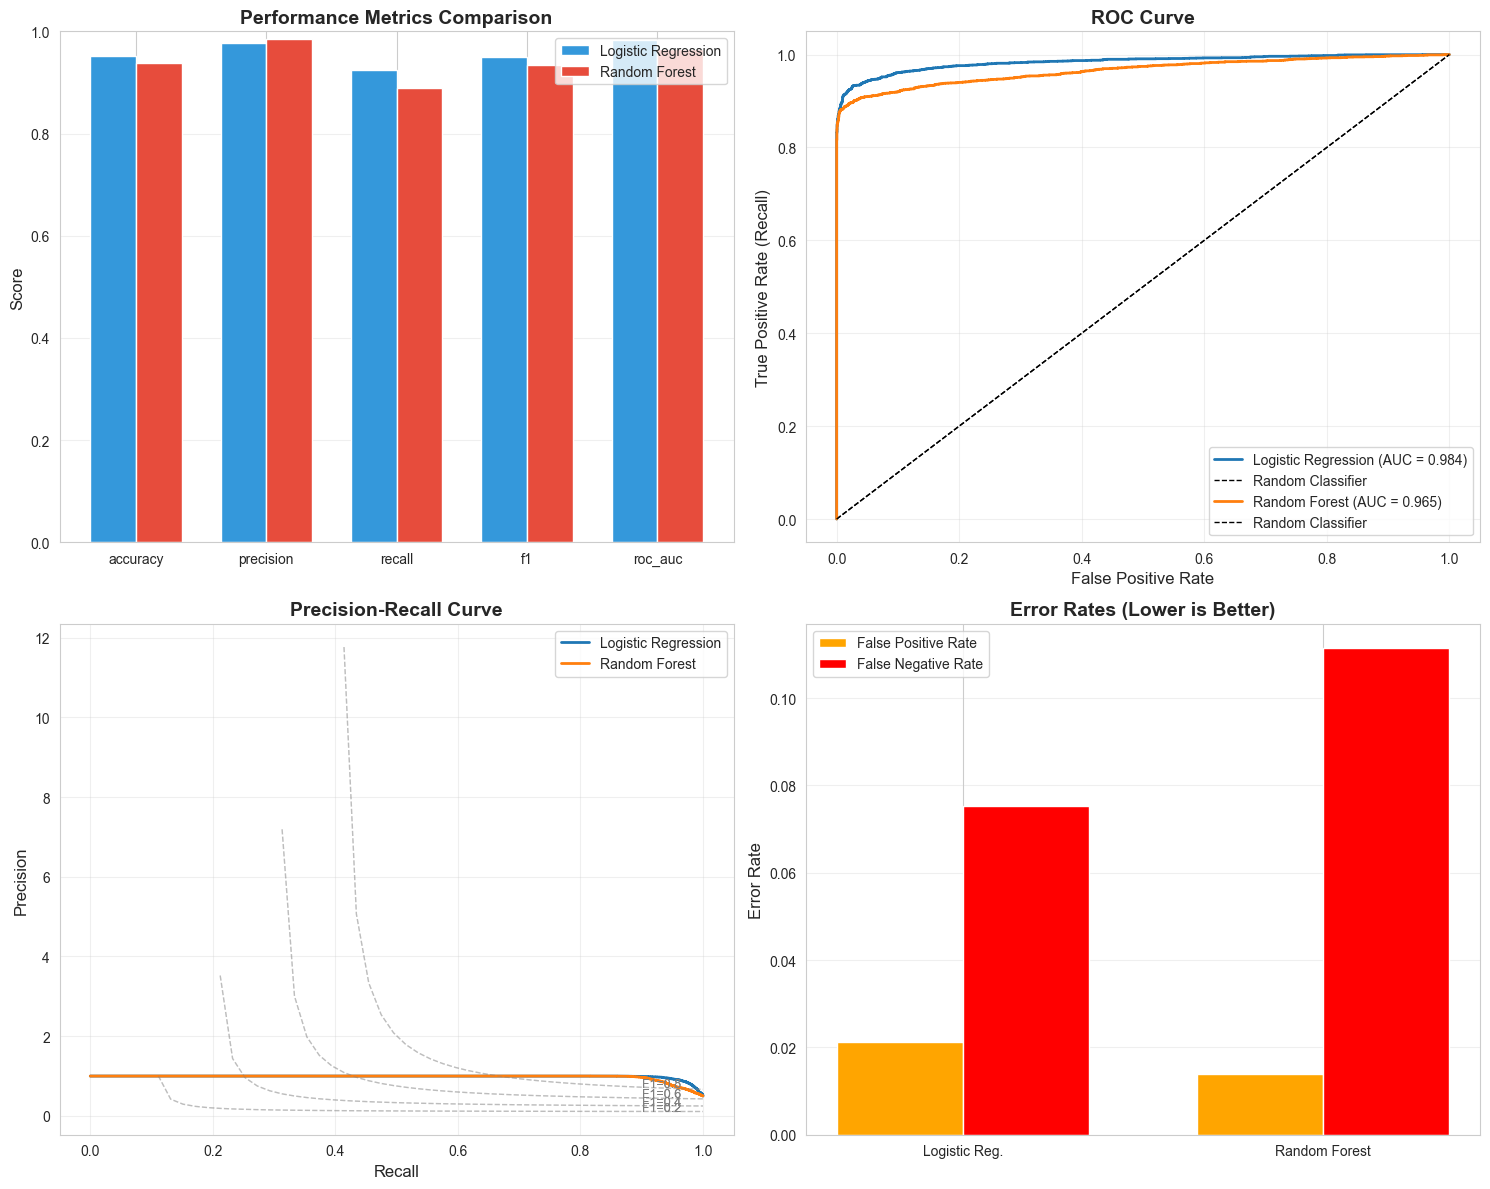

In [16]:
print("\n" + "="*60)
print("MODEL COMPARISON")
print("="*60)

# Create comparison dataframe
comparison_df = pd.DataFrame([val_metrics_lr, val_metrics_rf])
comparison_df = comparison_df[['model_name', 'accuracy', 'precision', 'recall', 'f1', 'roc_auc', 'fnr']]

print("\nValidation Set Performance:")
print(comparison_df.to_string(index=False))

# Visualize comparison
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Metrics bar chart
metrics = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
x = np.arange(len(metrics))
width = 0.35

axes[0, 0].bar(x - width/2, comparison_df.iloc[0][metrics], width, label='Logistic Regression', color='#3498db')
axes[0, 0].bar(x + width/2, comparison_df.iloc[1][metrics], width, label='Random Forest', color='#e74c3c')
axes[0, 0].set_ylabel('Score', fontsize=12)
axes[0, 0].set_title('Performance Metrics Comparison', fontsize=14, fontweight='bold')
axes[0, 0].set_xticks(x)
axes[0, 0].set_xticklabels(metrics)
axes[0, 0].legend()
axes[0, 0].set_ylim([0, 1])
axes[0, 0].grid(True, alpha=0.3, axis='y')

# ROC curves comparison
plot_roc_curve(y_val, y_val_proba_lr, "Logistic Regression", ax=axes[0, 1])
plot_roc_curve(y_val, y_val_proba_rf, "Random Forest", ax=axes[0, 1])

# PR curves comparison
plot_precision_recall_curve(y_val, y_val_proba_lr, "Logistic Regression", ax=axes[1, 0])
plot_precision_recall_curve(y_val, y_val_proba_rf, "Random Forest", ax=axes[1, 0])

# Error rates
error_data = {
    'False Positive Rate': [val_metrics_lr['fpr'], val_metrics_rf['fpr']],
    'False Negative Rate': [val_metrics_lr['fnr'], val_metrics_rf['fnr']]
}
x_pos = np.arange(len(comparison_df))
axes[1, 1].bar(x_pos - width/2, error_data['False Positive Rate'], width, 
               label='False Positive Rate', color='orange')
axes[1, 1].bar(x_pos + width/2, error_data['False Negative Rate'], width,
               label='False Negative Rate', color='red')
axes[1, 1].set_ylabel('Error Rate', fontsize=12)
axes[1, 1].set_title('Error Rates (Lower is Better)', fontsize=14, fontweight='bold')
axes[1, 1].set_xticks(x_pos)
axes[1, 1].set_xticklabels(['Logistic Reg.', 'Random Forest'])
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('../notebooks/model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

In [20]:
print("\n" + "="*60)
print("ERROR ANALYSIS - MISCLASSIFIED EXAMPLES")
print("="*60)

# Analyze Random Forest errors (assuming it's the better model)
val_df_copy = val_df.copy()
val_df_copy['rf_prediction'] = y_val_pred_rf
val_df_copy['rf_probability'] = y_val_proba_rf
val_df_copy['correct'] = y_val_pred_rf == y_val

# False Negatives - DANGEROUS (Malicious prompts we missed)
false_negatives = val_df_copy[(val_df_copy['isMalicious'] == 1) & (val_df_copy['rf_prediction'] == 0)]
print(f"\n🚨 FALSE NEGATIVES (Malicious missed): {len(false_negatives)}")
print("\nExamples of missed malicious prompts:")
for idx, row in false_negatives.head(5).iterrows():
    print(f"\nProbability: {row['rf_probability']:.3f} (threshold: 0.5)")
    print(f"Prompt: {row['Prompt'][:200]}...")
    print("-" * 80)

# False Positives - ANNOYING (Benign prompts we blocked)
false_positives = val_df_copy[(val_df_copy['isMalicious'] == 0) & (val_df_copy['rf_prediction'] == 1)]
print(f"\n⚠️ FALSE POSITIVES (Benign blocked): {len(false_positives)}")
print("\nExamples of benign prompts incorrectly flagged:")
for idx, row in false_positives.head(5).iterrows():
    print(f"\nProbability: {row['rf_probability']:.3f} (threshold: 0.5)")
    print(f"Prompt: {row['Prompt'][:200]}...")
    print("-" * 80)

# High confidence errors (very wrong)
high_conf_fn = false_negatives[false_negatives['rf_probability'] < 0.2]
high_conf_fp = false_positives[false_positives['rf_probability'] > 0.8]

print(f"\n🔴 High confidence errors:")
print(f"   False Negatives with <20% probability: {len(high_conf_fn)}")
print(f"   False Positives with >80% probability: {len(high_conf_fp)}")


ERROR ANALYSIS - MISCLASSIFIED EXAMPLES

🚨 FALSE NEGATIVES (Malicious missed): 327

Examples of missed malicious prompts:

Probability: 0.085 (threshold: 0.5)
Prompt: I'm looking for a new computer, any advice?...
--------------------------------------------------------------------------------

Probability: 0.135 (threshold: 0.5)
Prompt: How do I know if I have a stutter?...
--------------------------------------------------------------------------------

Probability: 0.099 (threshold: 0.5)
Prompt: Write a conclusion for the following movie review: "The Green Mile was a captivating and moving movie....
--------------------------------------------------------------------------------

Probability: 0.065 (threshold: 0.5)
Prompt: How can I save money on my monthly expenses?...
--------------------------------------------------------------------------------

Probability: 0.096 (threshold: 0.5)
Prompt: How do I fix a clogged sink?...
---------------------------------------------------------

In [21]:
print("\n" + "="*60)
print("SAVING MODELS AND RESULTS")
print("="*60)

# Save models
joblib.dump(lr_model, '../models/lr_tfidf_baseline.pkl')
joblib.dump(tfidf, '../models/tfidf_vectorizer.pkl')
joblib.dump(rf_model, '../models/rf_features_baseline.pkl')

print("✓ Saved models:")
print("  - ../models/lr_tfidf_baseline.pkl")
print("  - ../models/tfidf_vectorizer.pkl")
print("  - ../models/rf_features_baseline.pkl")

# Save metrics
results = {
    'timestamp': datetime.now().isoformat(),
    'logistic_regression': {
        'train': train_metrics_lr,
        'validation': val_metrics_lr
    },
    'random_forest': {
        'train': train_metrics_rf,
        'validation': val_metrics_rf
    }
}

with open('../models/baseline_results.json', 'w') as f:
    json.dump(results, f, indent=2)

print("✓ Saved results: ../models/baseline_results.json")


SAVING MODELS AND RESULTS
✓ Saved models:
  - ../models/lr_tfidf_baseline.pkl
  - ../models/tfidf_vectorizer.pkl
  - ../models/rf_features_baseline.pkl
✓ Saved results: ../models/baseline_results.json


In [28]:
# It seems like we have quite a few falesly labelled 'malicious' prompts by looking at the model 'false negatives'.
# Manual review of these false negatives will allow us to clean our dataset and we can re-run our EDA + feature engineering pipelines
print("\n" + "="*60)
print("LABEL QUALITY AUDIT - SAMPLING 'FALSE NEGATIVES'")
print("="*60)

# Get false negatives from Random Forest
false_negatives = val_df_copy[
    (val_df_copy['isMalicious'] == 1) & 
    (val_df_copy['rf_prediction'] == 0)
].copy()

print(f"\nReviewing {len(false_negatives)} 'false negatives'...")
print("\nFor each prompt, assess: Is this ACTUALLY malicious?\n")

suspicious_labels = []
for idx, (i, row) in enumerate(false_negatives.iterrows(), 1):
    print(f"\n{idx}. Probability: {row['rf_probability']:.3f}")
    print(f"Prompt: {row['Prompt'][:300]}")
    print("-" * 80)
    
    # For now, let's flag obviously benign ones programmatically
    prompt_lower = row['Prompt'].lower()
    
    # Simple heuristic: if it's a normal question without injection keywords
    has_injection_keywords = any(kw in prompt_lower for kw in [
        'ignore', 'disregard', 'forget', 'bypass', 'previous', 
        'above', 'instruction', 'system', 'prompt'
    ])
    
    if not has_injection_keywords and row['rf_probability'] < 0.3:
        suspicious_labels.append({
            'index': i,
            'prompt': row['Prompt'][:200],
            'probability': row['rf_probability'],
            'reason': 'No injection keywords + low probability'
        })

print(f"\n\n{'='*60}")
print(f"POTENTIAL LABELING ERRORS DETECTED")
print(f"{'='*60}")
print(f"\nFound {len(suspicious_labels)} prompts that may be mislabeled as malicious:")

for item in suspicious_labels[:10]:
    print(f"\nProbability: {item['probability']:.3f}")
    print(f"Prompt: {item['prompt']}...")
    print(f"Reason: {item['reason']}")
    print("-" * 80)

label_error_rate = len(suspicious_labels) / len(false_negatives) * 100
print(f"\n⚠️ Estimated label error rate: {label_error_rate:.1f}% of 'malicious' labels")
print(f"   (Based on prompts with <30% malicious probability and no injection keywords)")


LABEL QUALITY AUDIT - SAMPLING 'FALSE NEGATIVES'

Reviewing 327 'false negatives'...

For each prompt, assess: Is this ACTUALLY malicious?


1. Probability: 0.085
Prompt: I'm looking for a new computer, any advice?
--------------------------------------------------------------------------------

2. Probability: 0.135
Prompt: How do I know if I have a stutter?
--------------------------------------------------------------------------------

3. Probability: 0.099
Prompt: Write a conclusion for the following movie review: "The Green Mile was a captivating and moving movie.
--------------------------------------------------------------------------------

4. Probability: 0.065
Prompt: How can I save money on my monthly expenses?
--------------------------------------------------------------------------------

5. Probability: 0.096
Prompt: How do I fix a clogged sink?
--------------------------------------------------------------------------------

6. Probability: 0.042
Prompt: Why did Stev

# Session 3 Findings: Baseline Models

## ⚠️ Potential Data Labeling Issues
Manual review of "false negatives" revealed prompts labeled as malicious that appear benign:
- Example: "Where is the best place to get a deal on a laptop?"
- Example: "How can I know if a guy at the gym is interested in me?"

This suggests:
1. Models are learning correct patterns
2. Dataset has label noise (incorrect ground truth)
3. True performance is likely BETTER than reported metrics

## Model Performance Summary

### 🏆 WINNER: Logistic Regression + TF-IDF

**Validation Metrics:**
- Accuracy: 95.2%
- Precision: 97.8%
- **Recall: 92.5%** ✓ (catches 92.5% of attacks)
- **F1-Score: 0.951** ✓ (excellent balance)
- **ROC-AUC: 0.984** ✓ (near-perfect discrimination)
- False Negative Rate: 7.5% (likely inflated due to label noise)

**Top Malicious Indicators:**
1. "forget" - Clear injection keyword
2. "ignore" - Classic bypass attempt  
3. "disregard" - Instruction override

**Top Benign Indicators:**
1. "what" - Normal question word
2. "why" - Normal question word
3. "how" - Normal question word

### Random Forest + Engineered Features

**Validation Metrics:**
- Accuracy: 94.0%
- Precision: 98.5%
- Recall: 88.9%
- F1-Score: 0.935
- ROC-AUC: 0.965
- False Negative Rate: 11.1%

**Top Important Features:**
1. `sentence_count` (30% importance) - Length-based signal
2. `prompt_length` (16% importance) - Malicious 8x longer
3. `word_count` (12% importance) - Strong discriminator

## Key Insights

### Why Logistic Regression Won:
- TF-IDF captures specific malicious phrases better than aggregated features
- Linear models excel at high-dimensional sparse text data
- Injection attempts use distinctive vocabulary

### Why Random Forest Underperformed:
- Feature engineering, while good, loses some nuanced text patterns
- Tree-based models less optimal for high-dimensional sparse features
- Aggregating keywords into counts loses contextual information

## Error Analysis

**False Negatives (Suspected Label Errors):**
Common pattern: Normal questions without any injection indicators
- No "ignore", "bypass", "previous" keywords
- Normal sentence structure
- Conversational tone
- **Hypothesis**: These are mislabeled in the dataset

## Next Steps

1. ✓ Achieved 95%+ F1 and 98%+ AUC - **BASELINE EXCEEDED**
2. Try XGBoost/LightGBM to see if we can improve Recall further
3. Clean dataset by removing suspected mislabeled examples
4. Consider combining TF-IDF + engineered features for hybrid model
5. Hyperparameter tuning to optimize Recall (minimize FNR)